# SPLF Backtest — End-to-End with Visualization

This notebook runs the full pipeline (optionally including downloads) and visualizes results for an easy overview.

Phases:
- Create: download (optional) → build 1m bars → compute 5m features → run backtest → analyze metrics
- Visualize: plot 1m prices/basis/spread/flows and overlay alerts; inspect selected 5m features


In [20]:
# Bootstrap: ensure repo root on sys.path for `splf` imports
from pathlib import Path
import sys
root = Path.cwd()
if not (root / 'splf').exists():
    root = root.parent
sys.path.insert(0, str(root))
print('Repo root:', root)

# Optional: verify environment quickly
# %pip install pyarrow fastparquet matplotlib  # if needed in current kernel


Repo root: /home/thaomeo/tinhn/splf_backtest


In [21]:
# Config and helper imports
from splf.utils.io import load_yaml
from splf.notebook import SPLFNotebook
import pandas as pd
import matplotlib.pyplot as plt

CFG_PATH = root / 'config' / 'config.yaml'
cfg = load_yaml(str(CFG_PATH))
paths = cfg['paths']
uni = cfg.get('universe', {})
symbols = uni.get('symbols') or (uni.get('tier_a', []) + uni.get('tier_b', []) + uni.get('tier_c', []))
SYMBOLS = symbols or ['BTCUSDT']
SYMBOL = SYMBOLS[0]
SYMBOL, len(SYMBOLS)


('ETHUSDT', 1)

In [22]:
# Execution toggles
DO_DOWNLOAD = False   # downloads are large; enable if needed
DO_BUILD = True
DO_FEATURES = True
DO_BACKTEST = True
DO_ANALYZE = True

nb = SPLFNotebook(CFG_PATH)

In [23]:
# 1) Download (optional — large)
if DO_DOWNLOAD:
    nb.download(symbols=SYMBOLS)
'done' if DO_DOWNLOAD else 'skipped'


'skipped'

In [24]:
# 2) Build minute bars
df1m_map = {}
if DO_BUILD:
    out = nb.build_minute(SYMBOLS, return_df=True)
    df1m_map = {k: v for k, v in out.items()}
len(df1m_map), list(df1m_map)[:3]


Minute bars: 100%|████████████████████████████████████████████████████████████████████| 1/1 [06:53<00:00, 413.66s/it]


(1, ['ETHUSDT'])

In [25]:
# 3) Compute features (5m)
df5m_map = {}
if DO_FEATURES:
    out = nb.features(SYMBOLS, return_df=True)
    df5m_map = {k: v for k, v in out.items()}
len(df5m_map), list(df5m_map)[:3]


Features:   0%|                                                                                | 0/1 [00:00<?, ?it/s]/home/thaomeo/tinhn/splf_backtest/splf/feature_engine/features.py:35: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df[f"basis_TWAP_{w}m"] = df["basis_now"].rolling(f"{w}T", min_periods=max(2, w)).mean()
/home/thaomeo/tinhn/splf_backtest/splf/feature_engine/features.py:35: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df[f"basis_TWAP_{w}m"] = df["basis_now"].rolling(f"{w}T", min_periods=max(2, w)).mean()
/home/thaomeo/tinhn/splf_backtest/splf/feature_engine/features.py:40: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df[f"premium_TWAP_{w}m"] = df["premium"].rolling(f"{w}T", min_periods=max(2, w)).mean()
/home/thaomeo/tinhn/splf_backtest/splf/feature_engine/features.py:40: FutureWarning: 'T' is deprecated 

(1, ['ETHUSDT'])

In [26]:
# 4) Run backtest
alerts_map = {}
if DO_BACKTEST:
    alerts_map = nb.backtest(SYMBOLS)
len(alerts_map), list(alerts_map)[:3]


Backtest:   0%|                                                                                | 0/1 [00:00<?, ?it/s]/home/thaomeo/tinhn/splf_backtest/splf/backtesting/runner.py:109: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  aligned = df_1m.join(scores_5m[["if_score", "threshold", "storm_raw", "leader_state"]].resample("1T").ffill(), how="left")
/home/thaomeo/tinhn/splf_backtest/splf/backtesting/runner.py:110: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  aligned["storm_raw"] = aligned["storm_raw"].fillna(False)
/home/thaomeo/tinhn/splf_backtest/splf/backtesting/runner.py:119: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  closes_5m = aligned.index.floor("5

(1, ['ETHUSDT'])

In [27]:
# 5) Analyze metrics
metrics = {}
outcomes = pd.DataFrame()
if DO_ANALYZE:
    metrics, outcomes = nb.analyze(SYMBOLS)
metrics, outcomes.head() if not outcomes.empty else outcomes


Analyze:   0%|                                                                                 | 0/1 [00:00<?, ?it/s]/home/thaomeo/tinhn/splf_backtest/splf/notebook.py:139: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  price_1m = pd.read_parquet(p_min)["perp_mark"].fillna(method="ffill").fillna(method="bfill")
Analyze: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.33s/it]


({'T30_p80': {'precision': 0.5211581291759465,
   'recall': 1.0,
   'f1': 0.685212298682284,
   'tp': 234,
   'fp': 215,
   'fn': 0},
  'T30_p90': {'precision': 0.38530066815144765,
   'recall': 1.0,
   'f1': 0.5562700964630225,
   'tp': 173,
   'fp': 276,
   'fn': 0},
  'T60_p80': {'precision': 0.8841870824053452,
   'recall': 1.0,
   'f1': 0.9385342789598109,
   'tp': 397,
   'fp': 52,
   'fn': 0},
  'T60_p90': {'precision': 0.8285077951002228,
   'recall': 1.0,
   'f1': 0.9062119366626067,
   'tp': 372,
   'fp': 77,
   'fn': 0},
  'T90_p80': {'precision': 0.9643652561247216,
   'recall': 1.0,
   'f1': 0.981859410430839,
   'tp': 433,
   'fp': 16,
   'fn': 0},
  'T90_p90': {'precision': 0.9398663697104677,
   'recall': 1.0,
   'f1': 0.9690011481056257,
   'tp': 422,
   'fp': 27,
   'fn': 0},
  'T120_p80': {'precision': 1.0,
   'recall': 1.0,
   'f1': 1.0,
   'tp': 449,
   'fp': 0,
   'fn': 0},
  'T120_p90': {'precision': 0.9799554565701559,
   'recall': 1.0,
   'f1': 0.98987626546681

## Visualize Minute Bars (price, basis, spread, flow)
Shaded regions indicate data_ok = False (stale prices). Alerts are overlaid as red markers if available.


In [28]:
def false_ranges(mask: pd.Series):
    if mask.empty: return []
    bad = (~mask).astype(int)
    change = bad.diff().fillna(bad.iloc[0])
    starts = mask.index[change == 1]
    ends = mask.index[change == -1]
    if len(ends) < len(starts):
        ends = ends.insert(len(ends), mask.index[-1])
    return list(zip(starts, ends))

df1m = df1m_map.get(SYMBOL)
if df1m is None or df1m.empty:
    from pathlib import Path
    p_min = root / Path(paths['processed_dir']) / SYMBOL / 'minute.parquet'
    if p_min.exists():
        df1m = pd.read_parquet(p_min)
    else:
        df1m = pd.DataFrame()
df1m.head(2), df1m.shape


(                              index_px  perp_mark   premium  taker_buy_qty  \
 2025-06-01 00:00:00+00:00  2528.455349    2527.81 -0.000248       1036.020   
 2025-06-01 00:01:00+00:00  2525.862791    2525.18 -0.000007        859.083   
 
                            taker_sell_qty  vol_perp  taker_buy_qty_spot  \
 2025-06-01 00:00:00+00:00         730.939  1766.959            198.2498   
 2025-06-01 00:01:00+00:00        2537.101  3396.184             75.3471   
 
                            taker_sell_qty_spot  vol_spot  data_ok  
 2025-06-01 00:00:00+00:00              34.3711  232.6209     True  
 2025-06-01 00:01:00+00:00             209.7176  285.0647     True  ,
 (43200, 10))

/tmp/ipykernel_87593/1074783598.py:31: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  cvd15 = (df1m['taker_buy_qty'] - df1m['taker_sell_qty']).rolling('15T', min_periods=1).sum()


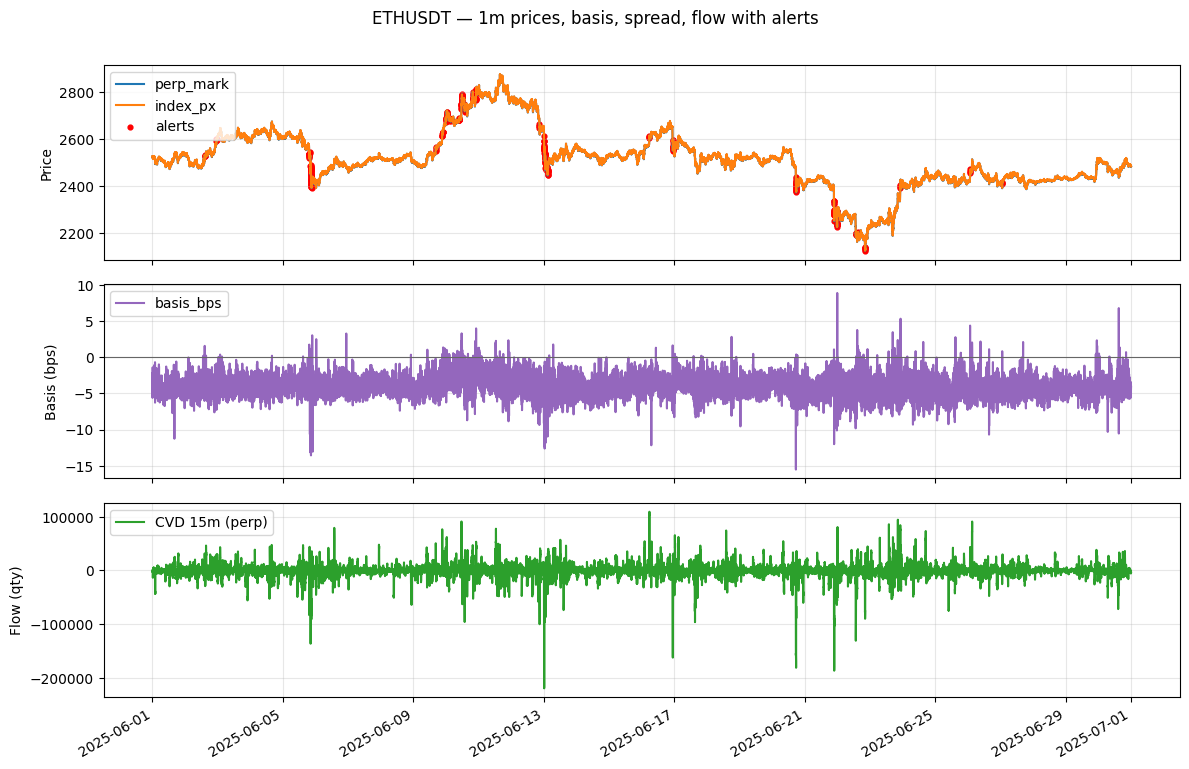

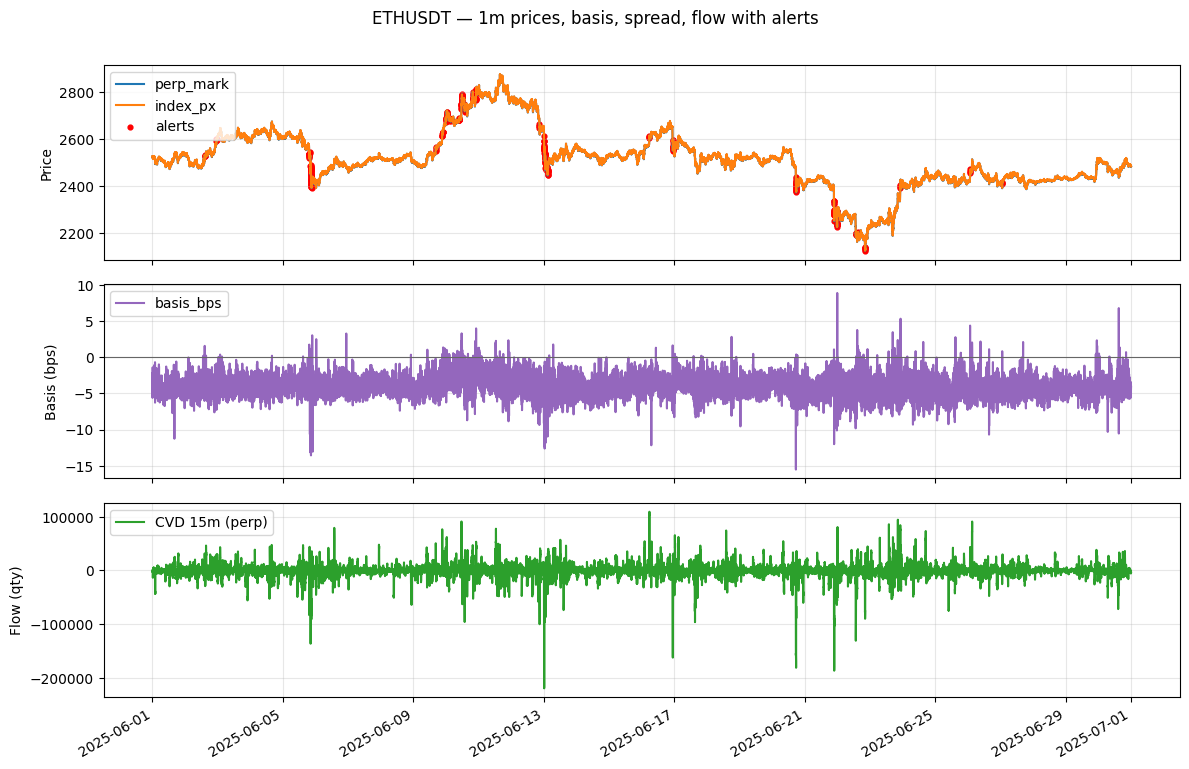

In [30]:
import numpy as np
fig_rows = 1
has_basis = {'perp_mark','index_px'}.issubset(df1m.columns)
has_spread = 'spread_bps' in df1m.columns
has_perp_flow = {'taker_buy_qty','taker_sell_qty'}.issubset(df1m.columns)
fig_rows += int(has_basis) + int(has_spread) + int(has_perp_flow)
fig, axes = plt.subplots(fig_rows, 1, figsize=(12, 2.6*fig_rows), sharex=True)
if fig_rows == 1: axes = [axes]
ax_i = 0
# Prices
ax = axes[ax_i]; ax_i += 1
for c in ['perp_mark','index_px']:
    if c in df1m.columns:
        ax.plot(df1m.index, df1m[c], label=c)
ax.set_ylabel('Price'); ax.legend(loc='upper left'); ax.grid(True, alpha=0.3)
# Basis (bps)
if has_basis:
    ax = axes[ax_i]; ax_i += 1
    basis_bps = (df1m['perp_mark'] - df1m['index_px']) / df1m['index_px'] * 10000.0
    ax.plot(df1m.index, basis_bps, color='tab:purple', label='basis_bps')
    ax.axhline(0, color='#666', lw=0.8)
    ax.set_ylabel('Basis (bps)'); ax.legend(loc='upper left'); ax.grid(True, alpha=0.3)
# Spread
if has_spread:
    ax = axes[ax_i]; ax_i += 1
    ax.plot(df1m.index, df1m['spread_bps'], color='tab:orange', label='spread_bps')
    ax.set_ylabel('Spread (bps)'); ax.legend(loc='upper left'); ax.grid(True, alpha=0.3)
# Perp flow imbalance (15m CVD)
if has_perp_flow:
    ax = axes[ax_i]; ax_i += 1
    cvd15 = (df1m['taker_buy_qty'] - df1m['taker_sell_qty']).rolling('15T', min_periods=1).sum()
    ax.plot(df1m.index, cvd15, color='tab:green', label='CVD 15m (perp)')
    ax.set_ylabel('Flow (qty)'); ax.legend(loc='upper left'); ax.grid(True, alpha=0.3)
# data_ok shading
if 'data_ok' in df1m.columns:
    for s, e in false_ranges(df1m['data_ok'].fillna(False)):
        for a in axes: a.axvspan(s, e, color='red', alpha=0.1)
# Overlay alerts
alerts = alerts_map.get(SYMBOL) if alerts_map else None
if alerts is None:
    from pathlib import Path
    p_alerts = root / Path(paths['artifacts_dir']) / 'alerts' / f'{SYMBOL}.csv'
    alerts = pd.read_csv(p_alerts, parse_dates=['ts']) if p_alerts.exists() else pd.DataFrame()
if not df1m.empty and not alerts.empty and 'perp_mark' in df1m.columns:
    axes[0].scatter(alerts['ts'], df1m.reindex(alerts['ts'])['perp_mark'], color='red', s=12, label='alerts')
    axes[0].legend(loc='upper left')
fig.suptitle(f'{SYMBOL} — 1m prices, basis, spread, flow with alerts'); fig.autofmt_xdate(); fig.tight_layout(rect=[0,0,1,0.97])
fig


## Visualize Selected 5m Features


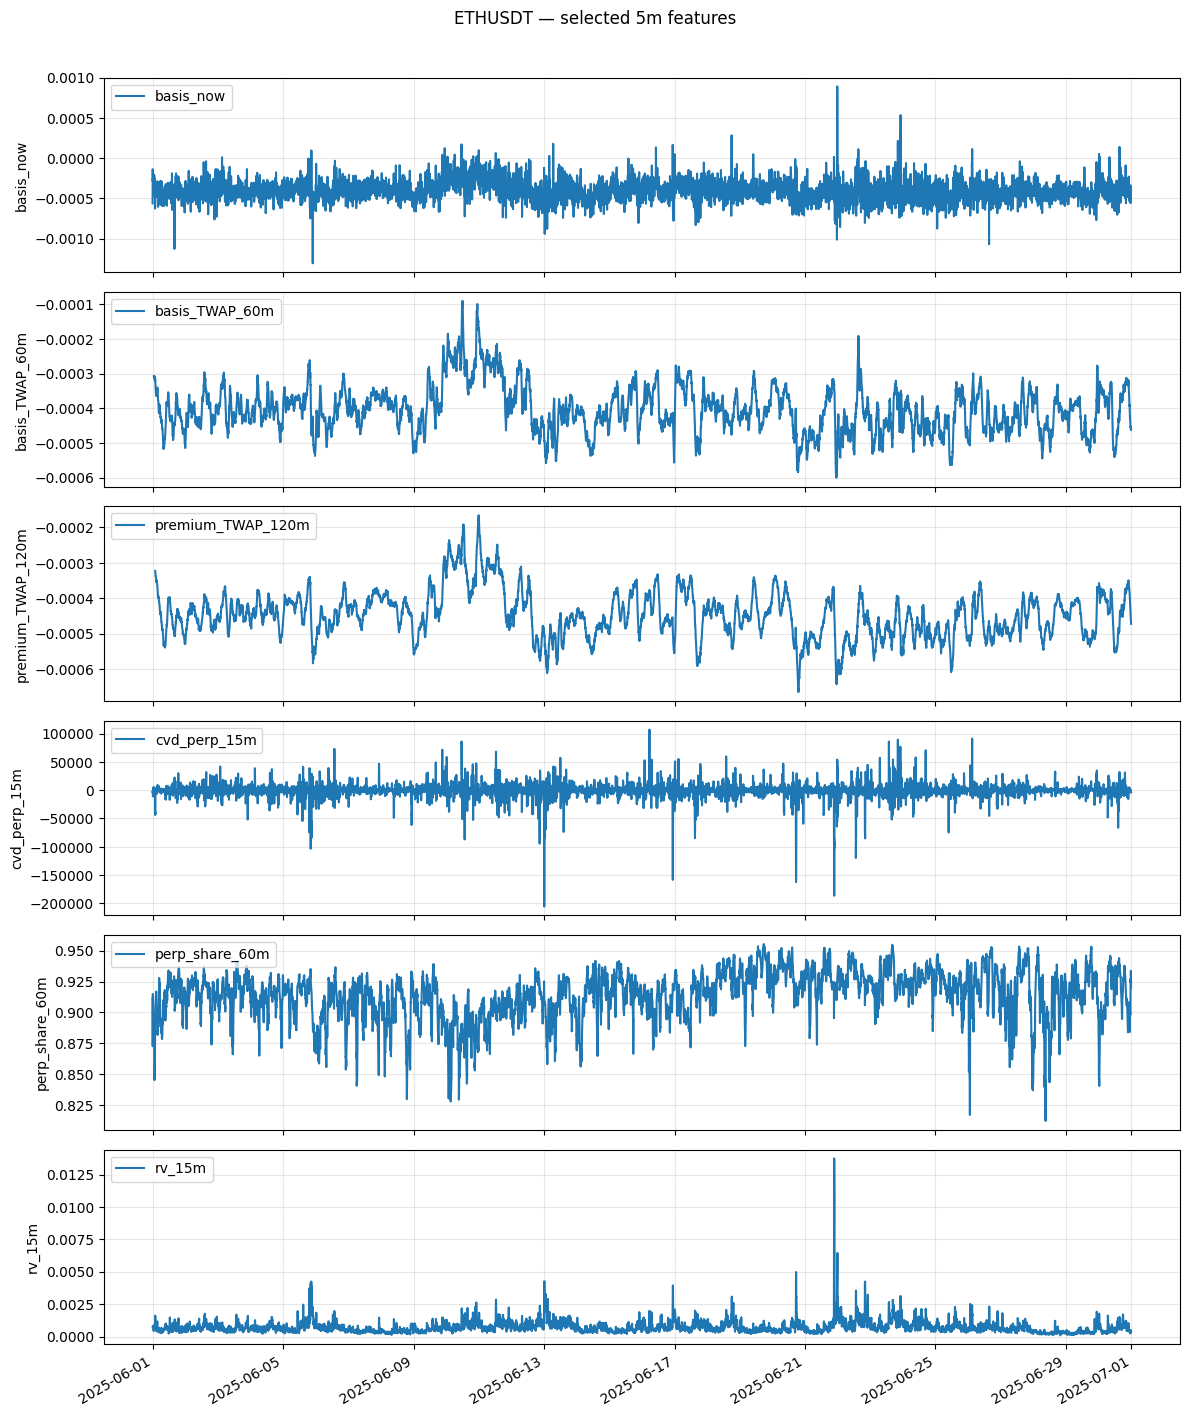

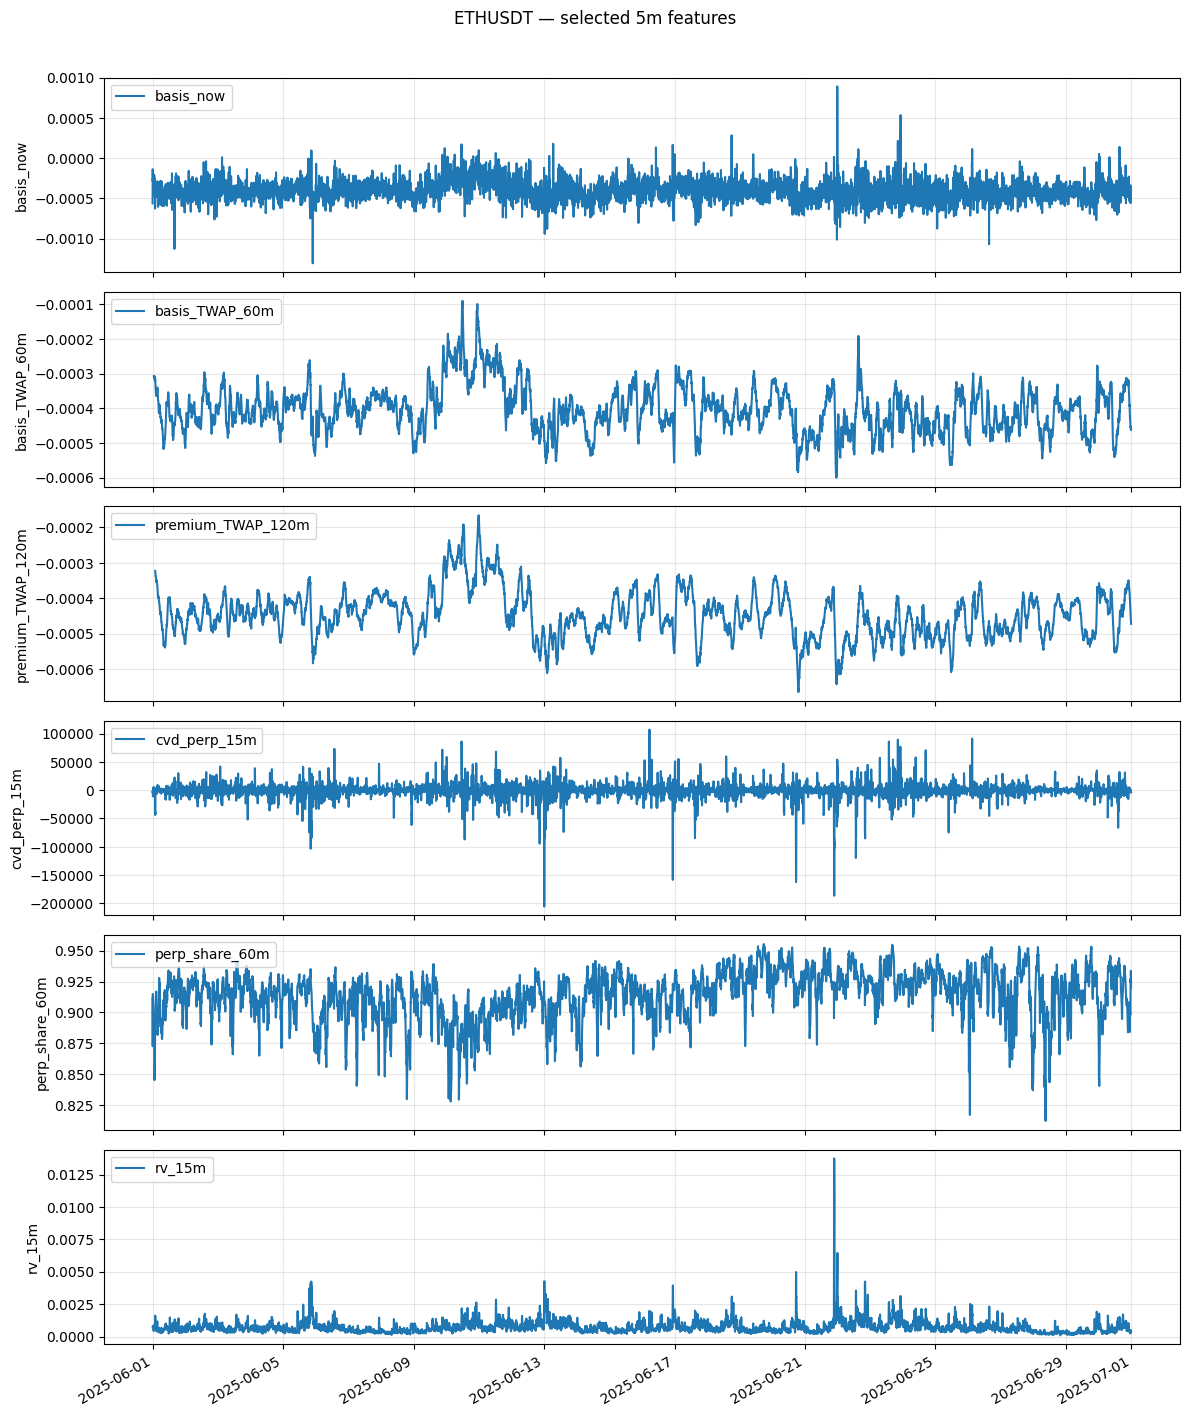

In [31]:
df5 = df5m_map.get(SYMBOL) if df5m_map else None
if df5 is None or (isinstance(df5, pd.DataFrame) and df5.empty):
    from pathlib import Path
    p_feat = root / Path(paths['features_dir']) / SYMBOL / 'features_5m.parquet'
    df5 = pd.read_parquet(p_feat) if p_feat.exists() else pd.DataFrame()
sel = [c for c in ['basis_now','basis_TWAP_60m','premium_TWAP_120m','cvd_perp_15m','perp_share_60m','rv_15m'] if c in df5.columns]
n = max(1, len(sel))
fig, axes = plt.subplots(n, 1, figsize=(12, 2.4*n), sharex=True)
if n == 1: axes = [axes]
for i, c in enumerate(sel):
    axes[i].plot(df5.index, df5[c], label=c)
    axes[i].set_ylabel(c); axes[i].grid(True, alpha=0.3); axes[i].legend(loc='upper left')
fig.suptitle(f'{SYMBOL} — selected 5m features'); fig.autofmt_xdate(); fig.tight_layout(rect=[0,0,1,0.97])
fig


## Metrics Summary


In [32]:
import json
from pathlib import Path
p_metrics = root / Path(paths['artifacts_dir']) / 'metrics' / 'metrics.json'
if p_metrics.exists():
    print('Metrics file:', p_metrics)
    print(json.dumps(json.load(open(p_metrics)), indent=2))
else:
    metrics if metrics else {}


Metrics file: /home/thaomeo/tinhn/splf_backtest/artifacts/metrics/metrics.json
{
  "T120_p80": {
    "f1": 1.0,
    "fn": 0,
    "fp": 0,
    "precision": 1.0,
    "recall": 1.0,
    "tp": 535
  },
  "T120_p90": {
    "f1": 0.9962476547842403,
    "fn": 0,
    "fp": 4,
    "precision": 0.9925233644859813,
    "recall": 1.0,
    "tp": 531
  },
  "T30_p80": {
    "f1": 0.6317135549872123,
    "fn": 0,
    "fp": 288,
    "precision": 0.4616822429906542,
    "recall": 1.0,
    "tp": 247
  },
  "T30_p90": {
    "f1": 0.5281980742778543,
    "fn": 0,
    "fp": 343,
    "precision": 0.35887850467289717,
    "recall": 1.0,
    "tp": 192
  },
  "T60_p80": {
    "f1": 0.966183574879227,
    "fn": 0,
    "fp": 35,
    "precision": 0.9345794392523364,
    "recall": 1.0,
    "tp": 500
  },
  "T60_p90": {
    "f1": 0.8807531380753137,
    "fn": 0,
    "fp": 114,
    "precision": 0.7869158878504673,
    "recall": 1.0,
    "tp": 421
  },
  "T90_p80": {
    "f1": 0.9943609022556391,
    "fn": 0,
    "f